In [1]:
import tensorflow as tf
from keras.models import load_model, Model
from keras import backend as K
K.set_learning_phase(0)

sess = tf.Session()
K.set_session(sess)

model = load_model('models/top_model_weights.h5')



Using TensorFlow backend.
/home/carlos/anaconda3/lib/python3.6/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [2]:
gd = sess.graph.as_graph_def()
print(len(gd.node), 'Nodes')
gd.node[:2]

7854 Nodes


[name: "input_1"
 op: "Placeholder"
 attr {
   key: "dtype"
   value {
     type: DT_FLOAT
   }
 }
 attr {
   key: "shape"
   value {
     shape {
       dim {
         size: -1
       }
       dim {
         size: 224
       }
       dim {
         size: 224
       }
       dim {
         size: 3
       }
     }
   }
 }, name: "conv2d_1/random_uniform/shape"
 op: "Const"
 attr {
   key: "dtype"
   value {
     type: DT_INT32
   }
 }
 attr {
   key: "value"
   value {
     tensor {
       dtype: DT_INT32
       tensor_shape {
         dim {
           size: 4
         }
       }
       tensor_content: "\003\000\000\000\003\000\000\000\003\000\000\000 \000\000\000"
     }
   }
 }]

In [3]:
nodes = {}

for node in gd.node:
    nodes[node.name] = node
    
nodes['input_1']

name: "input_1"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 224
      }
      dim {
        size: 224
      }
      dim {
        size: 3
      }
    }
  }
}

In [4]:
sess.graph.get_tensor_by_name('input_1:0')
#sess.graph.get_tensor_by_name('dense_1/Softmax:0')
model.get_input_shape_at(0)

(None, 224, 224, 3)

In [5]:
logs_path = './logdir'
tf.summary.FileWriter(logs_path, graph=sess.graph)

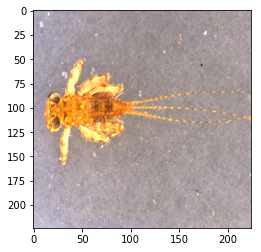

In [6]:
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
#img = Image.open('test/Calopterygidae/DMS10094.JPG')
img = Image.open('test/Heptageniidae/DMS10132.JPG')

img = img.resize((224, 224), Image.ANTIALIAS) # resizes image in-place
img = image.img_to_array(img)
img /=255
imgplot = plt.imshow(img)


In [7]:
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Loading image
DIM = 224
label_map = ['Calopterygidae', 'Heptageniidae']
img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Calopterygidae/DMS10089.JPG',
#img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Heptageniidae/DMS10132.JPG',
                    target_size=(DIM,DIM))

# Preprocessing image
img = image.img_to_array(img)
img /=255
#img -= 0.5
#img *= 2.
imgs = np.expand_dims(img, axis=0)

# Show image
# imgplot = plt.imshow(img)


# Tensorflow testing
x = tf.placeholder(tf.float32, shape=model.get_input_shape_at(0))
y = model(x)

#x = sess.graph.get_tensor_by_name('input_1:0')
#y = sess.graph.get_tensor_by_name('dense_1/Softmax:0')

orig_scores = sess.run(y, feed_dict={x: imgs})


def find_top_pred(scores):
    top_label_ix = np.argmax(scores)
    confidence = scores[0][top_label_ix]
    print('Label: {}, Confidence: {}'.format(label_map[top_label_ix], confidence))
    
find_top_pred(orig_scores)

Label: Calopterygidae, Confidence: 0.8281968832015991


In [ ]:
for node in gd.node:
    print(node.name, node.op)
    for index, inn in enumerate(node.input):
        print(index, inn)
    print(" ")

In [ ]:
for node in gd.node:
    print(node.name, node.op)
    for index, inn in enumerate(node.input):
        print(index, inn)
    print(" ")

In [ ]:
# nodes to reroute switch input
for n in [x for x in gd.node]:
    ints = [i for i in n.input]
    endswith1 = [ii for ii in ints if ii.endswith(':1')] #and 'Switch' in ii]
    if len(endswith1) > 0:
        for index, inn in enumerate(n.input):
            if inn in endswith1:
                new_input = inn[:-2]
                #n.input.remove(inn)
                #n.input.insert(index, new_input)

# SKIP THIS PLEASE,... 4 NOW


In [8]:
from tensorflow.python.framework import graph_util
#init_op = tf.initialize_all_variables()

#sess = tf.Session()
#sess.run(init_op)

output_graph_def = graph_util.convert_variables_to_constants(sess, gd, ['dense_1/Softmax'])


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.


In [9]:
with tf.gfile.GFile('graph.pb', "wb") as f:
    f.write(output_graph_def.SerializeToString())
    
K.clear_session()
sess = tf.Session()
K.set_session(sess)

from tensorflow.core.framework import graph_pb2
with open('graph.pb', "rb") as f:
    output_graph_def = graph_pb2.GraphDef()
    output_graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(output_graph_def, name="")
    
    
x = sess.graph.get_tensor_by_name('input_1:0')
y = sess.graph.get_tensor_by_name('dense_1/Softmax:0')

new_scores = sess.run(y, feed_dict={x: imgs})

print(new_scores)

abs((orig_scores - new_scores)) < 1e-6

[[ 0.82819688  0.17180313]]


array([[ True,  True]], dtype=bool)

In [10]:
x = sess.graph.get_tensor_by_name('input_1:0')
y = sess.graph.get_tensor_by_name('dense_1/Softmax:0')

new_scores = sess.run(y, feed_dict={x: imgs})

print(new_scores)

[[ 0.82819688  0.17180313]]
